In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install prince
!pip install xgboost

In [0]:
import pandas as pd
import numpy as np
import prince
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from xgboost import XGBClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train_data_df = pd.read_pickle("/content/drive/My Drive/ML/paper_data_train.pkl")
train_data_features = train_data_df.drop(columns=['paper_id','feature_extraction_encoding','tfidf_encoding','accepted'])
test_data_df = pd.read_pickle("/content/drive/My Drive/ML/paper_data_test.pkl")
test_data_features = test_data_df.drop(columns=['paper_id','feature_extraction_encoding','tfidf_encoding','accepted'])

In [0]:
train_data_df.iloc[0,2].size

5616

In [0]:
#DATASET FOR UNREDUCED
X_train_unreduced = train_data_features.applymap(lambda x: int(x) if isinstance(x, bool) else x).to_numpy()
X_test_unreduced = test_data_features.applymap(lambda x: int(x) if isinstance(x, bool) else x).to_numpy()

In [0]:
train_data_features.head()

,words_from_top_200_title,abstract_length,abstract_complexity,abstract_novelty,number_of_authors,research_strength_score,num_of_references,most_recent_ref_year,avg_len_of_ref_mention,num_of_recent_references,contains_githib_link,contains_appendix,number_of_sections,content_complexity,number_of_unique_words
0,True,136,8.265020,False,3,6.0,6,2016,90.833333,6,False,True,30,3.634356,55
1,True,198,9.676772,False,2,6.0,26,2016,0.000000,9,False,True,11,3.984653,69
2,True,140,7.654289,False,3,6.0,30,2016,109.228571,15,True,False,17,4.157808,52
3,False,163,8.715491,False,2,6.0,34,2016,42.326531,22,False,True,21,4.365226,49
4,True,110,7.268245,False,2,6.0,13,2016,59.066667,9,False,True,10,3.705192,74


In [0]:
train_paper_ids = train_data_df['paper_id']
train_paper_ids.to_pickle('train_data_paper_ids.pkl')

In [0]:
#TRAIN
for i in range(2,len(train_data_features.columns)+1):
    famd = prince.FAMD(n_components=i)
    famd = famd.fit(train_data_features)
    retained_variance = sum(famd.explained_inertia_)
    print("Variance retained for ",i," components = ",retained_variance)
    if retained_variance > 0.95:
        break

num_components = i
famd = prince.FAMD(n_components=num_components)
famd = famd.fit(train_data_features)
train_data_features_famd = famd.transform(train_data_features)
X_train = train_data_features_famd.to_numpy()
y_train = np.asarray([1 if item==True else 0 for item in list(train_data_df['accepted'])])

#TEST 
test_data_famd = famd.transform(test_data_features)
X_test = test_data_famd.to_numpy()
y_test = np.asarray([1 if item==True else 0 for item in list(test_data_df['accepted'])])

Variance retained for  2  components =  0.31140036255039005
Variance retained for  3  components =  0.4431749662695724
Variance retained for  4  components =  0.5437394843363514
Variance retained for  5  components =  0.6281410575147214
Variance retained for  6  components =  0.7042295163911692
Variance retained for  7  components =  0.7740263903321156
Variance retained for  8  components =  0.8393577505698252
Variance retained for  9  components =  0.8984498987238395
Variance retained for  10  components =  0.940110436199341
Variance retained for  11  components =  0.9616918112717446


# SVM with Features

In [0]:
parameters = {'kernel':('rbf','poly','sigmoid'), 'gamma':np.arange(1e-4,1e-2,0.0002),'C':range(1,100)}
svc_features = SVC()
clf_svc_features = GridSearchCV(svc_features, parameters,verbose=1,cv=3,n_jobs=-1)
clf_svc_features.fit(X_train,y_train)

In [0]:
filename = 'svc_features_model.sav'
pickle.dump(clf_svc_features, open(filename, 'wb'))
cv_results = clf_svc_features.cv_results_

In [0]:
#VALIDATION SCORE
best_params = clf_svc_features.best_params_
val_score = clf_svc_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'C': 50, 'gamma': 0.004700000000000001, 'kernel': 'rbf'}
VALIDATION SCORE = 0.6503094606542882


In [0]:
#TEST SCORE
clf_predictions = clf_svc_features.predict(X_test)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[43  1]
 [31  2]]
              precision    recall  f1-score   support

           0       0.58      0.98      0.73        44
           1       0.67      0.06      0.11        33

    accuracy                           0.58        77
   macro avg       0.62      0.52      0.42        77
weighted avg       0.62      0.58      0.46        77



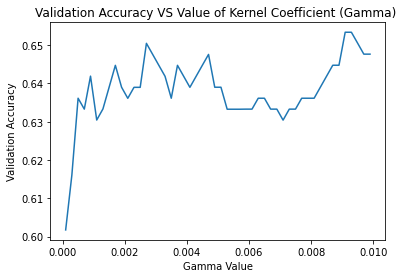

In [0]:
# Validation Accuracy VS Gamma
gamma = np.arange(1e-4,1e-2,0.0002)
accuracies = []
for val in gamma:
  svc = SVC(kernel = 'rbf',C = 50, gamma = val)
  scores = cross_val_score(svc, X_train, y_train, cv=3)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(gamma, accuracies)
plt.xlabel('Gamma Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Value of Kernel Coefficient (Gamma) ')
plt.show()

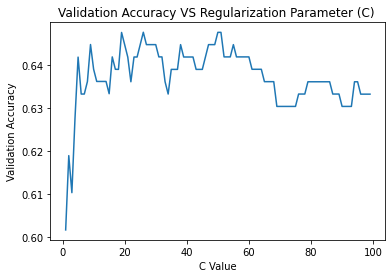

In [0]:
# Validation Accuracy VS C
C = range(1,100)
accuracies = []
for val in C:
  svc = SVC(kernel = 'rbf',C = val, gamma = 0.004700000000000001)
  scores = cross_val_score(svc, X_train, y_train, cv=3)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(C, accuracies)
plt.xlabel('C Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Regularization Parameter (C) ')
plt.show()

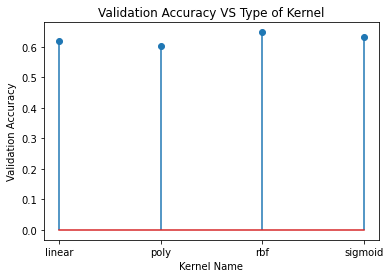

In [0]:
# Validation Accuracy VS Kernel
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = []
for val in kernel:
  svc = SVC(kernel = val,C = 50, gamma = 0.004700000000000001)
  scores = cross_val_score(svc, X_train, y_train, cv=3)
  accuracies.append(np.mean(scores))

plt.figure()
plt.stem(kernel, accuracies, use_line_collection = True)
plt.xlabel('Kernel Name')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Type of Kernel')
plt.show()

# LOGISTIC REGRESSION

In [0]:
parameters = {'penalty':('l1', 'l2', 'elasticnet'), 'C':range(1,100), 'fit_intercept':(True, False), 'class_weight':(None, 'balanced')}
lr_features = LogisticRegression(solver='liblinear', max_iter=200)
clf_lr_features = GridSearchCV(lr_features, param_grid=parameters, verbose=1, cv=3, n_jobs=-1)
clf_lr_features.fit(X_train, y_train)

Fitting 3 folds for each of 1188 candidates, totalling 3564 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2812 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3564 out of 3564 | elapsed:    4.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': range(1, 100), 'class_weight': (None, 'balanced'),
                         'fit_intercept': (True, False),
                         'penalty': ('l1', 'l2', 'elasticnet')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [0]:
filename = 'lr_features_model.sav'
pickle.dump(clf_lr_features, open(filename, 'wb'))
cv_results = clf_lr_features.cv_results_

In [0]:
best_params = clf_lr_features.best_params_
val_score = clf_lr_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'C': 1, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2'}
VALIDATION SCORE = 0.6533058257196188


In [0]:
clf_predictions = clf_lr_val.predict(X_test)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[42  2]
 [31  2]]
              precision    recall  f1-score   support

           0       0.58      0.95      0.72        44
           1       0.50      0.06      0.11        33

    accuracy                           0.57        77
   macro avg       0.54      0.51      0.41        77
weighted avg       0.54      0.57      0.46        77



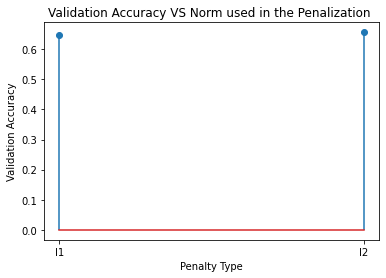

In [0]:
# Validation Accuracy VS Penalty
penalty = ['l1','l2']
accuracies = []
for val in penalty:
  lr = LogisticRegression(solver='liblinear', class_weight = None, C = 3, fit_intercept = True, penalty = val)
  scores = cross_val_score(lr, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.stem(penalty, accuracies, use_line_collection = True)
plt.xlabel('Penalty Type')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Norm used in the Penalization ')
plt.show()

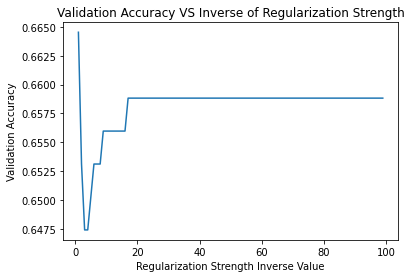

In [0]:
# Validation Accuracy VS C
C = range(1,100)
accuracies = []
for val in C:
  lr = LogisticRegression(solver='liblinear', class_weight = None, C = val, fit_intercept = True, penalty = 'l1', max_iter=200)
  scores = cross_val_score(lr, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(C, accuracies)
plt.xlabel('Regularization Strength Inverse Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Inverse of Regularization Strength')
plt.show()

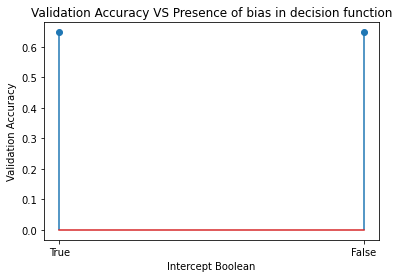

In [0]:
# Validation Accuracy VS Intercept Presence 
fit_intercept = ["True","False"]
accuracies = []
for val in fit_intercept:
  lr = LogisticRegression(solver='liblinear', class_weight = None, C = 3, fit_intercept = bool(val), penalty = 'l1')
  scores = cross_val_score(lr, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.stem(fit_intercept, accuracies, use_line_collection = True)
plt.xlabel('Intercept Boolean')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Presence of bias in decision function')
plt.show()

# RANDOM FOREST 

In [0]:
n_estimators = [50, 80, 100, 120, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

rf_features = RandomForestClassifier()
clf_rf_features = GridSearchCV(rf_features, hyperF, cv = 10, verbose = 1, n_jobs = -1)
clf_rf_features.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 63.9min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 64.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [0]:
filename = 'rf_features_model.sav'
pickle.dump(clf_rf_features, open(filename, 'wb'))
cv_results = clf_rf_features.cv_results_

In [0]:
best_params = clf_rf_features.best_params_
val_score = clf_rf_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
VALIDATION SCORE = 0.6563865546218487


In [0]:
clf_predictions = clf_rf_features.predict(X_test)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[40  4]
 [26  7]]
              precision    recall  f1-score   support

           0       0.61      0.91      0.73        44
           1       0.64      0.21      0.32        33

    accuracy                           0.61        77
   macro avg       0.62      0.56      0.52        77
weighted avg       0.62      0.61      0.55        77



100%|██████████| 8/8 [00:15<00:00,  1.91s/it]


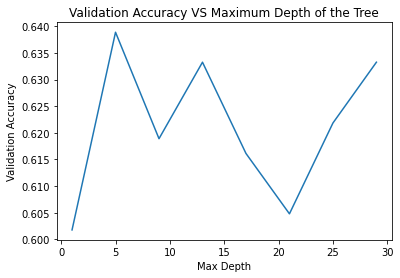

In [0]:
# Validation Accuracy VS Maximum Depth of the Tree  
#{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
max_depth = range(1,30,4)
accuracies = []
for val in tqdm(max_depth):
  rf = RandomForestClassifier(n_estimators=100,max_depth=val,min_samples_split=2,min_samples_leaf=5)
  scores = cross_val_score(rf, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(max_depth, accuracies)
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Maximum Depth of the Tree')
plt.show()

100%|██████████| 16/16 [01:10<00:00,  4.43s/it]


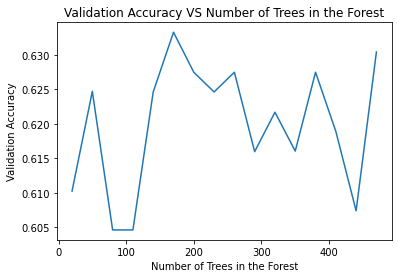

In [0]:
n_estimators = range(20,500,30)
accuracies = []
for val in tqdm(n_estimators):
  rf = RandomForestClassifier(n_estimators=val,max_depth=5,min_samples_split=2,min_samples_leaf=5)
  scores = cross_val_score(rf, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(n_estimators, accuracies)
plt.xlabel('Number of Trees in the Forest')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Number of Trees in the Forest')
plt.show()

100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


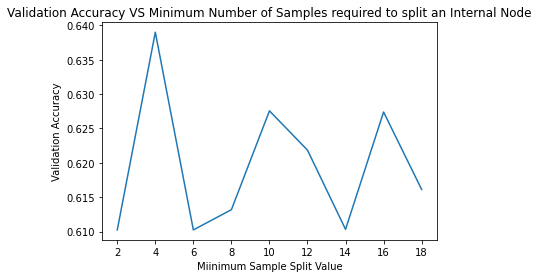

In [0]:
#{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
min_samples_split = range(2,20,2)
accuracies = []
for val in tqdm(min_samples_split):
  rf = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_split=val,min_samples_leaf=5)
  scores = cross_val_score(rf, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(min_samples_split, accuracies)
plt.xlabel('Miinimum Sample Split Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Minimum Number of Samples required to split an Internal Node')
plt.show()

100%|██████████| 9/9 [00:16<00:00,  1.80s/it]


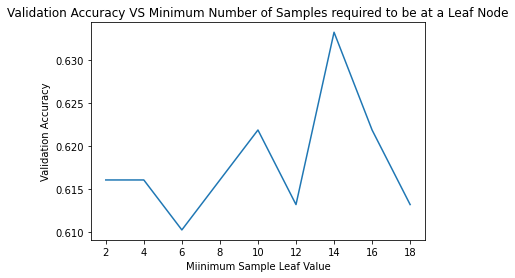

In [0]:
#{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
min_samples_leaf = range(1,10)
accuracies = []
for val in tqdm(min_samples_leaf):
  rf = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_split=2,min_samples_leaf=val)
  scores = cross_val_score(rf, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(min_samples_split, accuracies)
plt.xlabel('Miinimum Sample Leaf Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Minimum Number of Samples required to be at a Leaf Node')
plt.show()

# RANDOM FOREST ON UNREDUCED DATA

In [0]:
n_estimators = [50, 80, 100, 120, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

rf_features = RandomForestClassifier()
clf_rf_features = GridSearchCV(rf_features, hyperF, cv = 10, verbose = 1, n_jobs = -1)
clf_rf_features.fit(X_train_unreduced, y_train)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 58.0min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 69.3min
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed: 77.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [0]:
filename = 'rf_features_model_unreduced.sav'
pickle.dump(clf_rf_features, open(filename, 'wb'))
cv_results = clf_rf_features.cv_results_

In [0]:
best_params = clf_rf_features.best_params_
val_score = clf_rf_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 100, 'n_estimators': 100}
VALIDATION SCORE = 0.6703361344537816


In [0]:
clf_predictions = clf_rf_features.predict(X_test_unreduced)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[39  5]
 [22 11]]
              precision    recall  f1-score   support

           0       0.64      0.89      0.74        44
           1       0.69      0.33      0.45        33

    accuracy                           0.65        77
   macro avg       0.66      0.61      0.60        77
weighted avg       0.66      0.65      0.62        77



In [0]:
best_rf = RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=100, n_estimators=100)
best_rf.fit(X_train_unreduced, y_train)
best_rf_predictions = best_rf.predict(X_test_unreduced)

Tree number 11 from random forest


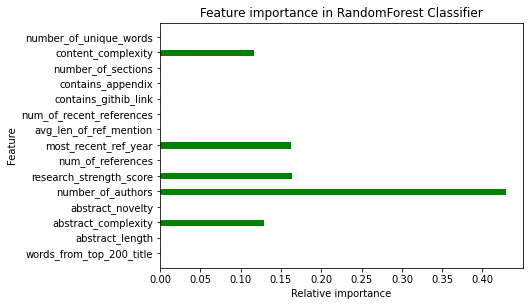

<Figure size 360x360 with 0 Axes>

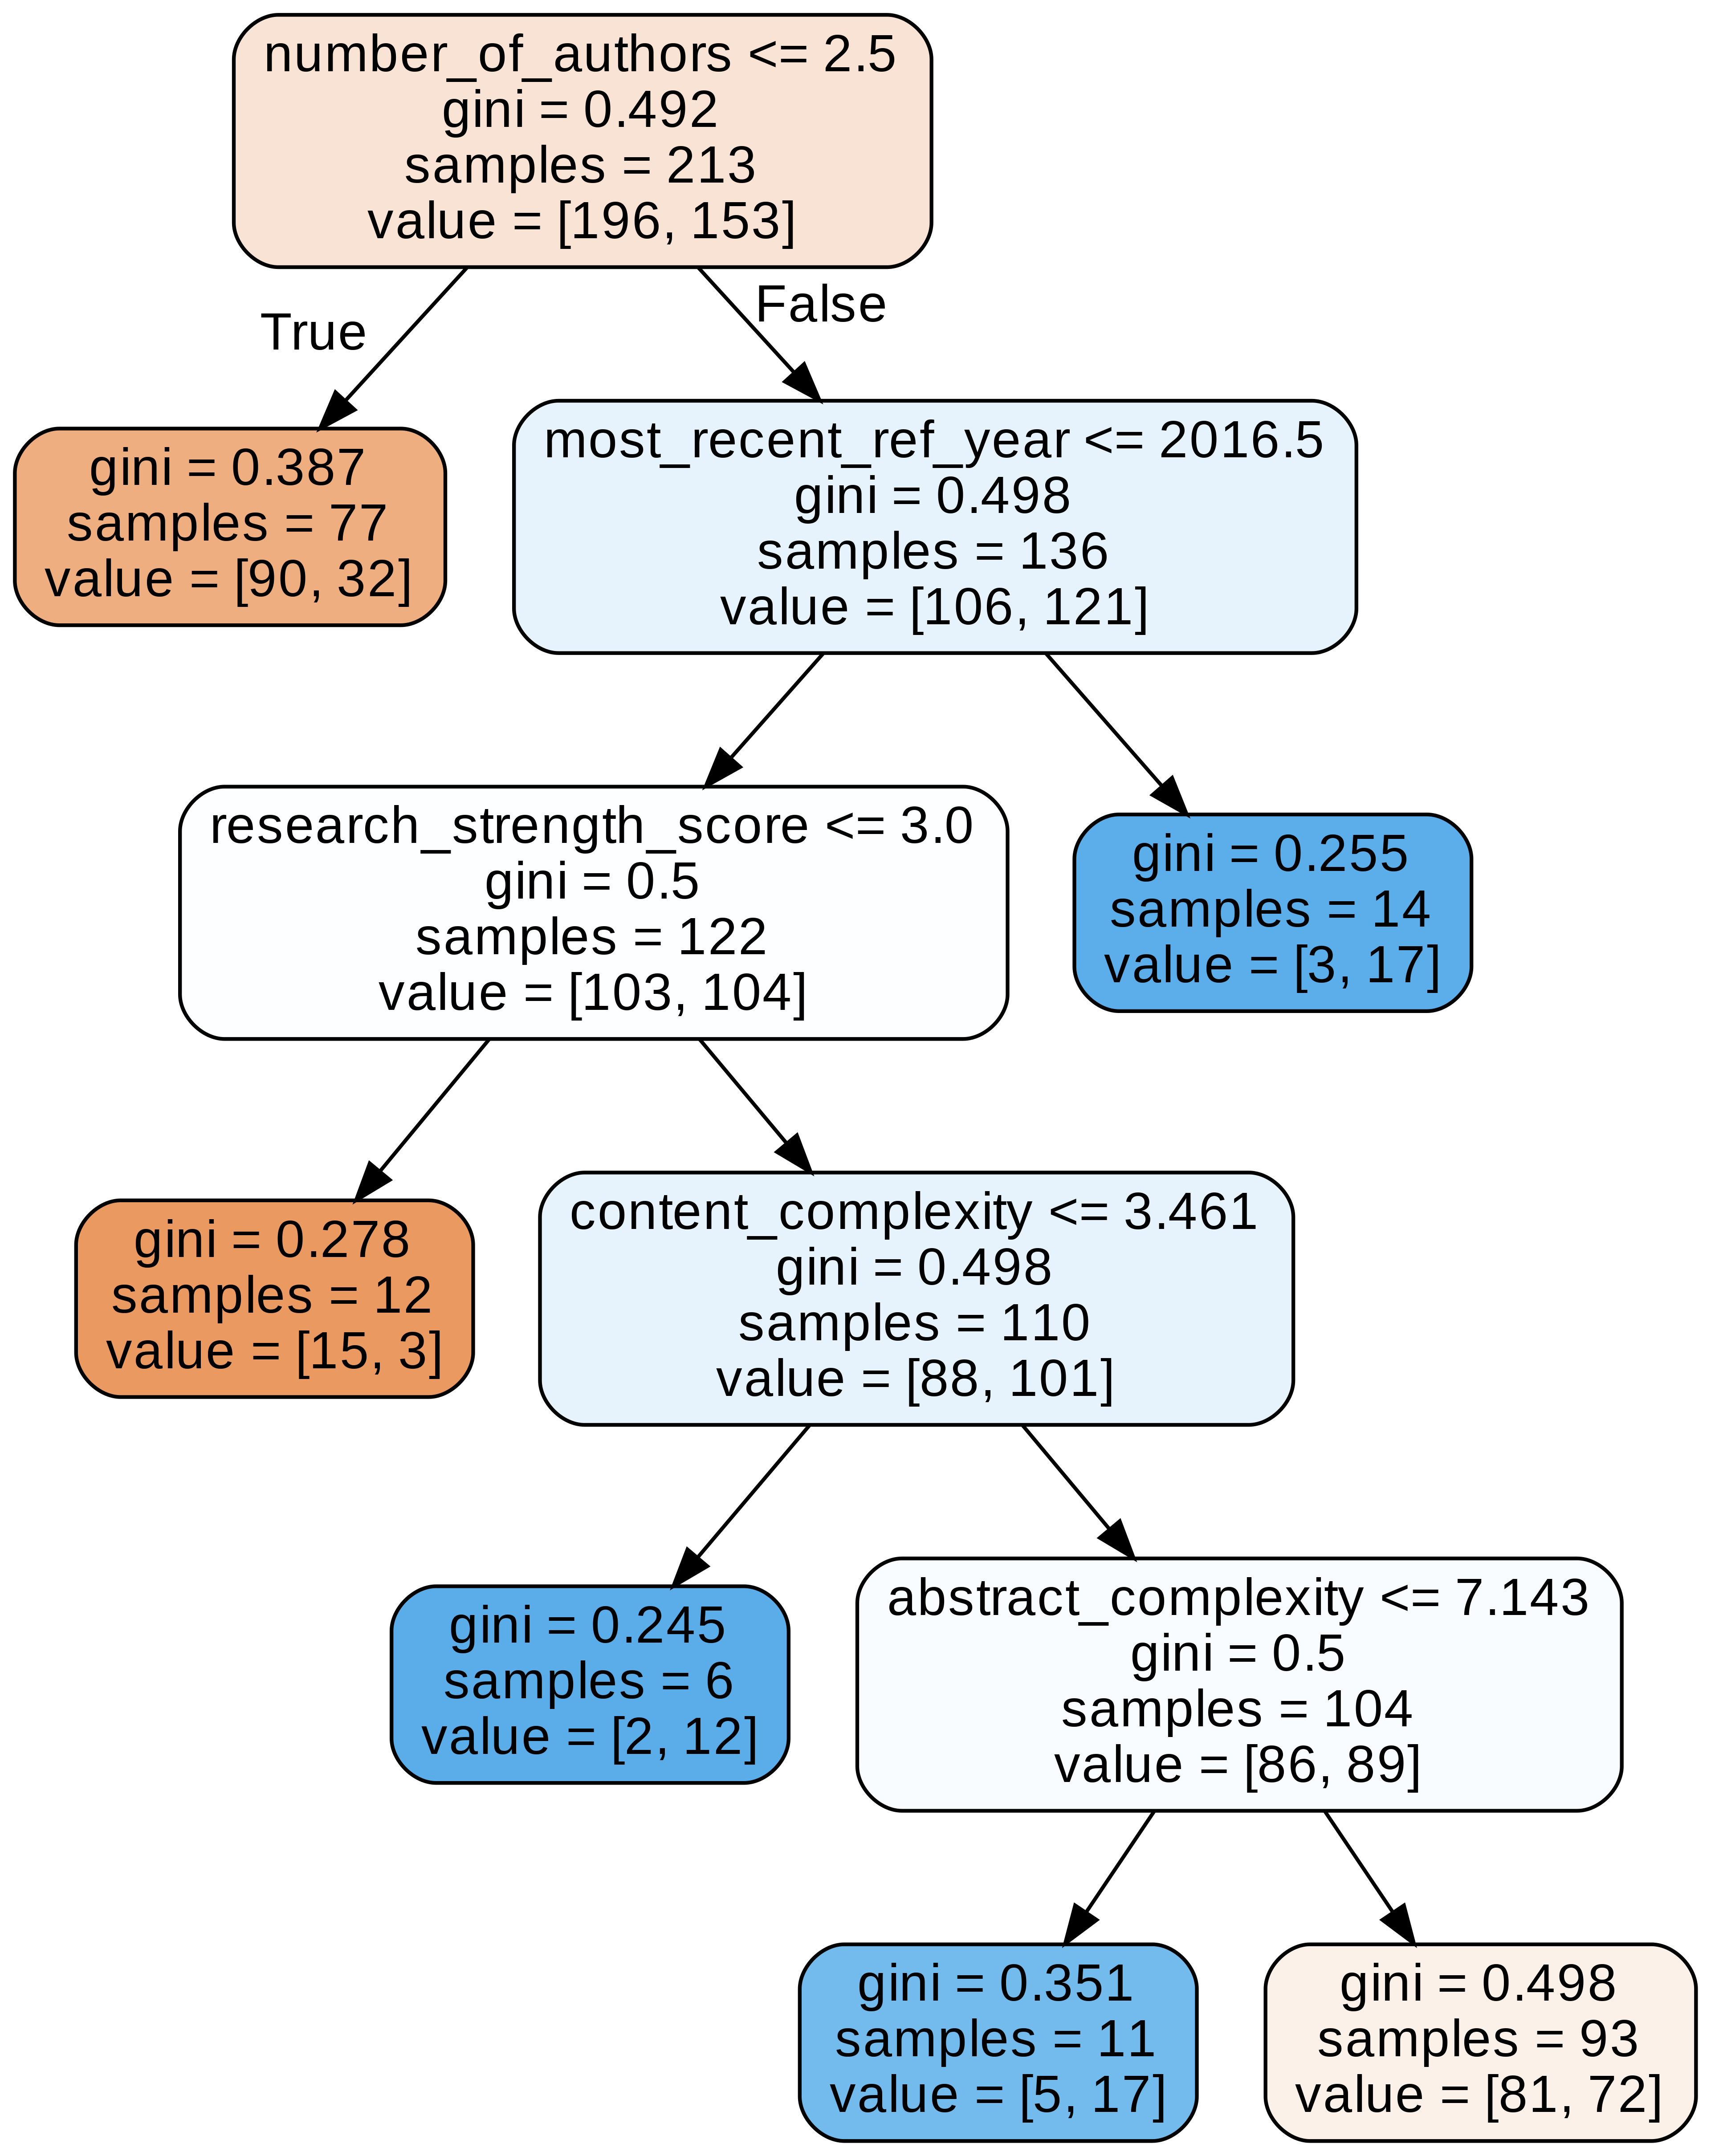

In [0]:
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree

non_zero_feature_importance_number = np.array([np.count_nonzero(estimator.feature_importances_) for estimator in best_rf.estimators_])
estimator_number = np.argmax(non_zero_feature_importance_number)
estimator =  best_rf.estimators_[estimator_number]
print("Tree number",estimator_number,"from random forest")

#FEATURE IMPORTANCE 
col = list(train_data_df.drop(columns=['paper_id','feature_extraction_encoding','tfidf_encoding','accepted']).columns)
y = estimator.feature_importances_
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)

plt.title("Feature importance in RandomForest Classifier")
plt.xlabel("Relative importance")
plt.ylabel("Feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)
plt.show()

dotfile = six.StringIO()
export_graphviz(estimator,out_file='tree.dot',
    feature_names=col,
    filled=True,
    rounded=True)
(graph,) = pydot.graph_from_dot_file('tree.dot')

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Tree number 48 from random forest
Tree number 91 from random forest
Tree number 94 from random forest
Tree number 80 from random forest


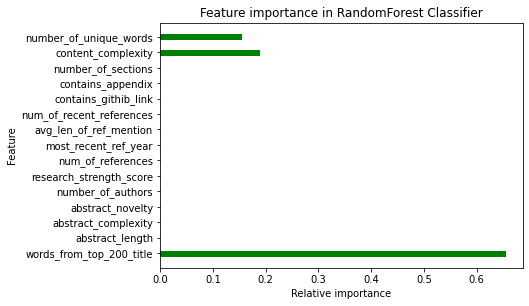

<Figure size 360x360 with 0 Axes>

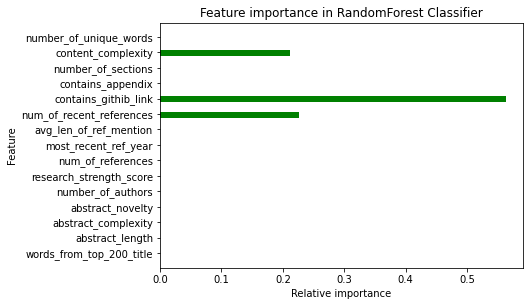

<Figure size 360x360 with 0 Axes>

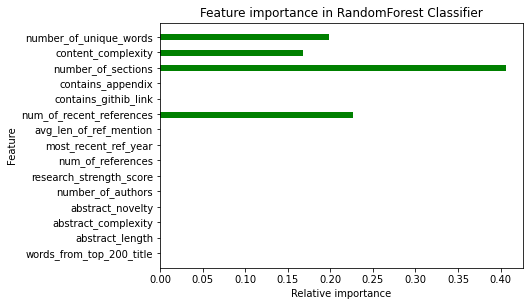

<Figure size 360x360 with 0 Axes>

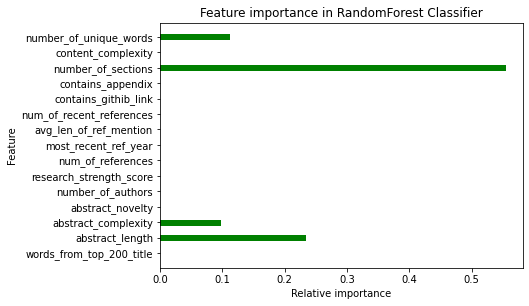

<Figure size 360x360 with 0 Axes>

In [0]:
import random

for i in range(0,4):
    estimator_number =  random.randint(0, 100) 
    estimator = best_rf.estimators_[estimator_number]
    
    print("Tree number",estimator_number,"from random forest")

    #FEATURE IMPORTANCE 
    col = list(train_data_df.drop(columns=['paper_id','feature_extraction_encoding','tfidf_encoding','accepted']).columns)
    y = estimator.feature_importances_
    fig, ax = plt.subplots() 
    width = 0.4 # the width of the bars 
    ind = np.arange(len(y)) # the x locations for the groups
    ax.barh(ind, y, width, color="green")
    ax.set_yticks(ind+width/10)
    ax.set_yticklabels(col, minor=False)

    plt.title("Feature importance in RandomForest Classifier")
    plt.xlabel("Relative importance")
    plt.ylabel("Feature") 
    plt.figure(figsize=(5,5))
    fig.set_size_inches(6.5, 4.5, forward=True)


In [0]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = train_data_features_unreduced.feature_names,
                class_names = iris.target_names,
                rounded = False, proportion = False, 
                precision = 2, filled = True)


# ADABOOST

In [0]:
base_estim = DecisionTreeClassifier(max_depth=1)
n_estimators = [50, 100, 250, 500]
learning_rate = [1e-4, 1e-3, 1e-2, 1e-1, 1]
hyperF = dict(n_estimators = n_estimators, learning_rate=learning_rate)

adaboost_features = AdaBoostClassifier(base_estimator=base_estim)
clf_adaboost_features = GridSearchCV(adaboost_features, hyperF, cv = 10, verbose = 1, n_jobs = -1)
clf_adaboost_features.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [0]:
filename = 'adaboost_features_model.sav'
pickle.dump(clf_adaboost_features, open(filename, 'wb'))
cv_results = clf_adaboost_features.cv_results_

In [0]:
best_params = clf_adaboost_features.best_params_
val_score = clf_adaboost_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'learning_rate': 0.01, 'n_estimators': 250}
VALIDATION SCORE = 0.6705882352941177


In [0]:
clf_predictions = clf_adaboost_features.predict(X_test)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[39  5]
 [27  6]]
              precision    recall  f1-score   support

           0       0.59      0.89      0.71        44
           1       0.55      0.18      0.27        33

    accuracy                           0.58        77
   macro avg       0.57      0.53      0.49        77
weighted avg       0.57      0.58      0.52        77



Text(0.5, 1.0, 'Validation Accuracy VS Number of estimators')

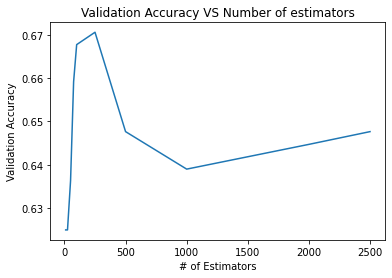

In [0]:
# Validation Accuracy VS Number of estimators
base_estim = DecisionTreeClassifier(max_depth=1)
learning_rate = 0.01
n_estimators = [10, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000, 2500]
accuracies = []
for val in n_estimators:
  adaboost = AdaBoostClassifier(base_estimator=base_estim, n_estimators=val, learning_rate=learning_rate)
  scores = cross_val_score(adaboost, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(n_estimators, accuracies)
plt.xlabel('# of Estimators')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Number of estimators')

Text(0.5, 1.0, 'Validation Accuracy VS Learning rate')

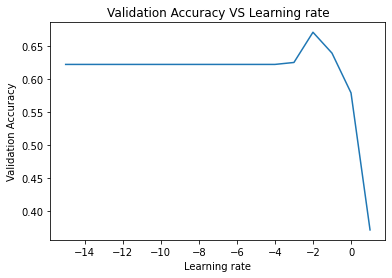

In [0]:
# Validation Accuracy VS Learning Rate
learning_rate = list(range(-15,2))
n_estimators = 250
accuracies = []
for val in learning_rate:
  adaboost = AdaBoostClassifier(base_estimator=base_estim, n_estimators=n_estimators, learning_rate=10**val)
  scores = cross_val_score(adaboost, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(learning_rate, accuracies)
plt.xlabel('Learning rate(log)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Learning rate')

# ADABOOST ON UNREDUCED FEATURES

In [0]:
base_estim = DecisionTreeClassifier(max_depth=1)
n_estimators = [50, 100, 250, 500]
learning_rate = [1e-4, 1e-3, 1e-2, 1e-1, 1]
hyperF = dict(n_estimators = n_estimators, learning_rate=learning_rate)

adaboost_features = AdaBoostClassifier(base_estimator=base_estim)
clf_adaboost_features = GridSearchCV(adaboost_features, hyperF, cv = 10, verbose = 1, n_jobs = -1)
clf_adaboost_features.fit(X_train_unreduced, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=1,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [0]:
filename = 'adaboost_features_model.sav'
pickle.dump(clf_adaboost_features, open(filename, 'wb'))
cv_results = clf_adaboost_features.cv_results_

In [0]:
best_params = clf_adaboost_features.best_params_
val_score = clf_adaboost_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'learning_rate': 0.1, 'n_estimators': 50}
VALIDATION SCORE = 0.6646218487394959


In [0]:
clf_predictions = clf_adaboost_features.predict(X_test_unreduced)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[37  7]
 [20 13]]
              precision    recall  f1-score   support

           0       0.65      0.84      0.73        44
           1       0.65      0.39      0.49        33

    accuracy                           0.65        77
   macro avg       0.65      0.62      0.61        77
weighted avg       0.65      0.65      0.63        77



# XGBOOST

In [0]:
eta = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
gamma = [1, 10, 100]
reg_lambda = [1e-1, 1, 10, 100]
alpha = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
hyperF = dict(eta=eta, reg_lambda=reg_lambda, alpha=alpha, gamma=gamma)

xgboost_features = XGBClassifier(max_depth=6)
clf_xgboost_features = GridSearchCV(xgboost_features, hyperF, cv = 10, verbose = 1, n_jobs = -1)
clf_xgboost_features.fit(X_train, y_train)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 6388 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:  7.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-05, 1e-06, 1e-07, 0.0001, 0.001, 0.01,
                                   0.1, 1],
                         'eta': [1e-05, 1e-06, 1e-07, 0.0

In [0]:
best_params = clf_xgboost_features.best_params_
val_score = clf_xgboost_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'alpha': 1e-05, 'eta': 1e-05, 'gamma': 10, 'reg_lambda': 1}
VALIDATION SCORE = 0.6391596638655461


In [0]:
clf_predictions = clf_xgboost_features.predict(X_test)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[38  6]
 [26  7]]
              precision    recall  f1-score   support

           0       0.59      0.86      0.70        44
           1       0.54      0.21      0.30        33

    accuracy                           0.58        77
   macro avg       0.57      0.54      0.50        77
weighted avg       0.57      0.58      0.53        77



Text(0.5, 1.0, 'Validation Accuracy VS Reg_lambda')

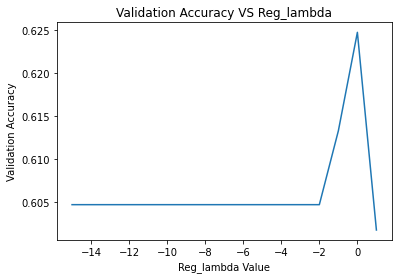

In [0]:
# Validation Accuracy VS lambda (L2 reg parameter)
eta = 1e-5
gamma = 10
lambda_vals = list(range(-15,2))
alpha = 1e-5
accuracies = []
for val in lambda_vals:
  xgboost_clf = XGBClassifier(gamma=gamma, alpha=alpha, eta=eta, reg_lambda=10**val)
  scores = cross_val_score(xgboost_clf, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(lambda_vals, accuracies)
plt.xlabel('Reg_lambda Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Reg_lambda')

Text(0.5, 1.0, 'Validation Accuracy VS Alpha')

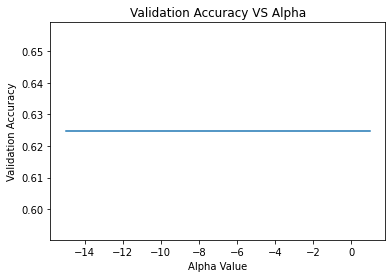

In [0]:
# Validation Accuracy VS alpha (L1 reg parameter)
eta = 1e-5
gamma = 10
reg_lambda = 1
alpha_vals = list(range(-15,2))
accuracies = []
for val in alpha_vals:
  xgboost_clf = XGBClassifier(gamma=gamma, alpha=10**val, eta=eta, reg_lambda=reg_lambda)
  scores = cross_val_score(xgboost_clf, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(alpha_vals, accuracies)
plt.xlabel('Alpha Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Alpha')

Text(0.5, 1.0, 'Validation Accuracy VS ETA (Learning Rate)')

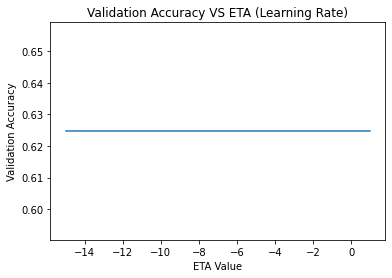

In [0]:
# Validation Accuracy VS eta (Learning Rate)
eta_vals = list(range(-15,2))
gamma = 10
reg_lambda = 1
alpha = 1e-5
accuracies = []
for val in eta_vals:
  xgboost_clf = XGBClassifier(gamma=gamma, alpha=alpha, eta=10**eta, reg_lambda=reg_lambda)
  scores = cross_val_score(xgboost_clf, X_train, y_train, cv=10)
  accuracies.append(np.mean(scores))

plt.figure()
plt.plot(eta_vals, accuracies)
plt.xlabel('ETA Value')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS ETA (Learning Rate)')

# XGBOOST WITH UNREDUCED FEATURES

In [0]:
eta = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
gamma = [1, 10, 100]
reg_lambda = [1e-1, 1, 10, 100]
alpha = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
hyperF = dict(eta=eta, reg_lambda=reg_lambda, alpha=alpha, gamma=gamma)

xgboost_features = XGBClassifier(max_depth=6)
clf_xgboost_features = GridSearchCV(xgboost_features, hyperF, cv = 10, verbose = 1, n_jobs = -1)
clf_xgboost_features.fit(X_train_unreduced, y_train)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1460 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2360 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3460 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 6260 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:  6.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1, 1],
                         'eta': [1e-07, 1e-06, 1e-05, 0.0

In [0]:
best_params = clf_xgboost_features.best_params_
val_score = clf_xgboost_features.best_score_
print(best_params)
print("VALIDATION SCORE =", val_score)

{'alpha': 1e-07, 'eta': 1e-07, 'gamma': 1, 'reg_lambda': 100}
VALIDATION SCORE = 0.6358823529411763


In [0]:
clf_predictions = clf_xgboost_features.predict(X_test_unreduced)
print(confusion_matrix(y_test,clf_predictions))
print(classification_report(y_test,clf_predictions))

[[37  7]
 [20 13]]
              precision    recall  f1-score   support

           0       0.65      0.84      0.73        44
           1       0.65      0.39      0.49        33

    accuracy                           0.65        77
   macro avg       0.65      0.62      0.61        77
weighted avg       0.65      0.65      0.63        77

